<a href="https://colab.research.google.com/github/diego6289/CAP4630/blob/master/HW_4/HW_4_3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modified VGG16 with Different Classifier

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-21 06:03:57--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 2a00:1450:4013:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   171MB/s    in 0.4s    

2020-04-21 06:03:58 (171 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [4]:
from keras.applications import VGG16

conv_base = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

conv_base.trainable = True

Using TensorFlow backend.


58892288/58889256 [==============================] - 2s 0us/step


In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))   # data augmentation with densely connected layer
model.add(layers.Dense(1, activation='sigmoid'))    # classifier 1

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1' or layer.name == 'blocks4_conv1':    # unfreezing these layers
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 25s 251ms/step - loss: 0.4991 - acc: 0.7585 - val_loss: 0.3248 - val_acc: 0.8690
Epoch 2/30
100/100 [==============================] - 18s 183ms/step - loss: 0.3453 - acc: 0.8450 - val_loss: 0.2903 - val_acc: 0.8940
Epoch 3/30
100/100 [==============================] - 18s 183ms/step - loss: 0.2849 - acc: 0.8730 - val_loss: 0.1775 - val_acc: 0.9100
Epoch 4/30
100/100 [==============================] - 18s 181ms/step - loss: 0.2612 - acc: 0.8855 - val_loss: 0.1144 - val_acc: 0.9240
Epoch 5/30
100/100 [==============================] - 18s 182ms/step - loss: 0.2324 - acc: 0.9010 - val_loss: 0.1745 - val_acc: 0.9230
Epoch 6/30
100/100 [==============================] - 18s 183ms/step - loss: 0.2124 - acc: 0.9175 - val_loss: 0.1172 - val_acc: 0.9280
Epoch 7/30
100/100 [==============================] - 18s 182ms/step - loss: 0.2080 - acc: 0.9170 - val_lo

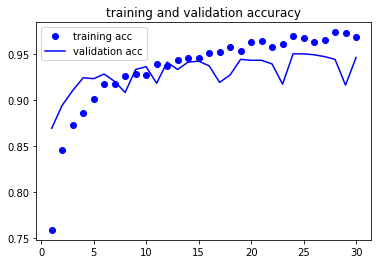

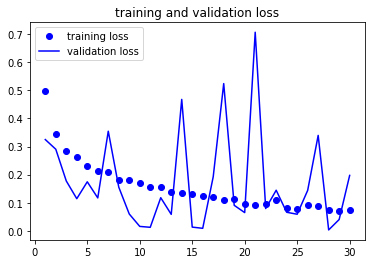

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [9]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.18101951479911804
Validation accuracy: 0.9459999799728394
